# Passer Ratings: Hand Sizes

Hypothesis: Hand size effects average career passer rating.

In [79]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import mysql.connector
import sys
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import pymc3 as pm
sys.path.append('..')
from util.matching import match, distance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load

In [45]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
sql = open('../sql/qb_season_ratings.sql', 'r').read()
df = pd.read_sql(sql, cnx)
df = df.loc[:,~df.columns.duplicated()][df['attempts']>50].set_index(['player','year'])

## Clean

The dataset uses empty strings as missing values. We'll change that to NaN.

In [46]:
df = df.apply(lambda x: x.replace('', np.nan))

# physical
df.loc[df['hand']<1, 'hand'] = np.nan
df['hand'] = df.groupby('player')['hand'].apply(lambda x: x.fillna(method='ffill'))
df.loc[df['height']<1, 'height'] = np.nan
df.loc[df['weight']<1, 'weight'] = np.nan
df.loc[df['arm']<1, 'arm'] = np.nan

# combine
df.loc[df['broad']<1, 'broad'] = np.nan
df.loc[df['cone']<1, 'cone'] = np.nan
df.loc[df['shuttle']<1, 'shuttle'] = np.nan 

df.describe()

,attempts,completions,yards,interceptions,TD,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,...,vertical,broad,shuttle,cone,arm,hand,dpos,start,jnum,dcp
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,...,1014.000000,528.000000,551.000000,539.000000,485.000000,515.00000,1014.000000,1014.000000,1014.000000,1014.000000
mean,346.623274,211.994083,2435.874753,9.706114,14.737673,80.376627,0.067296,0.030572,0.084831,0.423961,...,17.377712,111.323864,4.283013,7.121744,32.135309,9.59213,57.834320,2003.830375,3.279093,0.696252
std,197.733500,128.141549,1511.868073,5.688563,11.215744,15.095219,0.027190,0.094902,0.109693,0.269861,...,16.140787,6.963120,0.167032,0.229315,1.047378,0.46930,73.885134,7.164602,5.075347,1.101218
min,51.000000,18.000000,167.000000,0.000000,0.000000,16.700000,0.000000,0.000000,0.000000,0.000000,...,0.000000,96.000000,3.900000,6.660000,28.500000,8.25000,0.000000,1985.000000,0.000000,0.000000
25%,160.250000,93.000000,1020.750000,5.000000,5.000000,71.025000,0.048425,0.000000,0.000000,0.200000,...,0.000000,106.000000,4.175000,6.950000,31.250000,9.26800,1.000000,1999.000000,0.000000,0.000000
50%,341.500000,204.000000,2321.500000,9.000000,12.000000,81.050000,0.064000,0.000000,0.058800,0.333300,...,26.500000,111.000000,4.280000,7.110000,32.000000,9.50000,22.000000,2004.000000,0.000000,0.000000
75%,525.750000,320.000000,3705.750000,14.000000,22.000000,90.600000,0.082775,0.000000,0.133300,0.666700,...,32.500000,116.000000,4.380000,7.210000,32.875000,9.87500,93.000000,2009.000000,7.000000,1.000000
max,787.000000,541.000000,6404.000000,30.000000,60.000000,121.000000,0.194000,0.750000,0.750000,1.000000,...,39.000000,127.000000,4.780000,7.800000,35.000000,10.87500,285.000000,2019.000000,19.000000,5.000000


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1014 entries, ('DB-3800', 2011) to ('SW-2400', 2000)
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attempts       1014 non-null   float64
 1   completions    1014 non-null   float64
 2   yards          1014 non-null   float64
 3   interceptions  1014 non-null   float64
 4   TD             1014 non-null   float64
 5   avg_rating     1014 non-null   float64
 6   sack_rate      1014 non-null   float64
 7   alt_rate       1014 non-null   float64
 8   precip_rate    1014 non-null   float64
 9   turf_rate      1014 non-null   float64
 10  wind_rate      1014 non-null   float64
 11  away_rate      1014 non-null   float64
 12  temp           1014 non-null   float64
 13  fname          1014 non-null   object 
 14  lname          1014 non-null   object 
 15  pname          1014 non-null   object 
 16  pos1           1014 non-null   object 
 17  pos2           83 non-n

Lets load in combine data we scraped outside of this notebook.

In [48]:
def fill(group, cols, data):
    group = group.reset_index(-1)
    for col in cols:
        if col not in group.columns:
            group[col] = np.nan
        group[col] = group[col].fillna(data[col])
    group = group.set_index('year', append=True)
    return group

In [49]:
qb_combine = pd.read_csv(f'../data/combine_qb_200309.csv', index_col=0)
cols = qb_combine.drop(['fname','lname'], axis=1).columns.values
qb_combine

,fname,lname,arm,hand,shuttle,cone,broad,wonderlic,ball_speed
player,,,,,,,,,
AB-2900,Aaron,Brooks,32.000,9.500,4.29,7.52,120.0,17.0,NaN
AF-0300,A.J.,Feeley,NaN,NaN,4.16,NaN,NaN,NaN,NaN
AS-1400,Akili,Smith,32.250,9.750,4.29,6.99,114.0,26.0,NaN
AS-1600,Alex,Smith,31.750,9.375,3.97,6.82,113.0,40.0,NaN
AV-0200,Alex,Van Pelt,31.880,9.750,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
TS-2600,Troy,Smith,31.000,8.250,4.24,7.25,NaN,NaN,NaN
TT-0900,Tyler,Thigpen,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT-0200,Vinny,Testaverde,33.500,10.000,NaN,NaN,NaN,NaN,NaN


Now fill the values in the dataframe

In [50]:
df = df.groupby('player').apply(lambda x: fill(x, cols, qb_combine))

In [51]:
df.loc['AB-2900', 'hand']

year
2001    9.5
2004    9.5
2002    9.5
2003    9.5
2005    9.5
2000    9.5
2006    9.5
Name: hand, dtype: float64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1014 entries, ('DB-3800', 2011) to ('SW-2400', 2000)
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attempts       1014 non-null   float64
 1   completions    1014 non-null   float64
 2   yards          1014 non-null   float64
 3   interceptions  1014 non-null   float64
 4   TD             1014 non-null   float64
 5   avg_rating     1014 non-null   float64
 6   sack_rate      1014 non-null   float64
 7   alt_rate       1014 non-null   float64
 8   precip_rate    1014 non-null   float64
 9   turf_rate      1014 non-null   float64
 10  wind_rate      1014 non-null   float64
 11  away_rate      1014 non-null   float64
 12  temp           1014 non-null   float64
 13  fname          1014 non-null   object 
 14  lname          1014 non-null   object 
 15  pname          1014 non-null   object 
 16  pos1           1014 non-null   object 
 17  pos2           83 non-n

In [52]:
df_subset = df.loc[:,['attempts','avg_rating','sack_rate','alt_rate','precip_rate','turf_rate','wind_rate','away_rate','temp','height','arm','start','hand']].reset_index()
df_subset

,player,year,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,arm,start,hand
0,DB-3800,2011,763.0,110.6,0.0365,0.0000,0.0000,0.7222,2.333333,0.5000,68.944444,72.0,31.250,2001,10.000
1,PM-0200,2013,787.0,111.7,0.0223,0.5263,0.0526,0.2632,7.526316,0.4211,57.578947,77.0,31.500,1998,10.130
2,EM-0200,2011,752.0,95.1,0.0493,0.0000,0.1000,0.7500,7.850000,0.5500,57.550000,77.0,30.750,2004,9.750
3,TB-2300,2011,722.0,104.8,0.0462,0.0526,0.0000,0.6316,7.842105,0.4211,55.000000,76.0,32.750,2000,9.380
4,MR-2500,2016,632.0,119.9,0.0661,0.0526,0.0526,0.7368,2.052632,0.4211,68.611111,77.0,32.375,2008,9.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,KD-0600,2005,56.0,45.1,0.0508,0.0000,0.2000,0.2000,4.200000,0.4000,61.600000,73.0,32.880,1998,8.000
1010,AW-2100,2000,53.0,31.7,0.1846,0.0000,0.0000,0.5000,11.250000,0.5000,49.750000,73.0,31.500,2000,9.500
1011,WG-0750,2019,52.0,33.2,0.1034,0.0000,0.0000,0.5000,4.500000,0.5000,66.500000,74.0,31.500,2019,9.375
1012,HB-0400,2002,51.0,27.2,0.0714,0.0000,0.0000,0.4000,8.000000,0.8000,50.200000,72.0,NaN,2002,NaN


In [53]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player       1014 non-null   object 
 1   year         1014 non-null   int64  
 2   attempts     1014 non-null   float64
 3   avg_rating   1014 non-null   float64
 4   sack_rate    1014 non-null   float64
 5   alt_rate     1014 non-null   float64
 6   precip_rate  1014 non-null   float64
 7   turf_rate    1014 non-null   float64
 8   wind_rate    1014 non-null   float64
 9   away_rate    1014 non-null   float64
 10  temp         1014 non-null   float64
 11  height       1014 non-null   float64
 12  arm          873 non-null    float64
 13  start        1014 non-null   int64  
 14  hand         881 non-null    float64
dtypes: float64(12), int64(2), object(1)
memory usage: 119.0+ KB


We now have a season-by-season dataframe for all quarterbacks, but we want career averages. We also drop QB's who only lasted 1 or 2 seasons or averaged less than 100 throws a season, which is very low. The averaged career statistics for these players would be less stable (essentially the opposite of the Law of Large Numbers).

In [54]:
def career_averages(group):
    row = {}
    for i, col in group.iteritems():
        if i!='player':
            row[i] = [col.mean()]
    row['seasons'] = [group['year'].max()-group['start'].min()]
    row.pop('year')
    new_group = pd.DataFrame.from_dict(row, orient='columns')
    return new_group

In [101]:
df_career = df_subset.groupby('player').apply(career_averages).reset_index(-1, drop=True)
df_career = df_career.loc[(df_career['seasons']>1) & (df_career['attempts']>100), :].dropna()
df_career.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, AB-2900 to VY-0100
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   attempts     146 non-null    float64
 1   avg_rating   146 non-null    float64
 2   sack_rate    146 non-null    float64
 3   alt_rate     146 non-null    float64
 4   precip_rate  146 non-null    float64
 5   turf_rate    146 non-null    float64
 6   wind_rate    146 non-null    float64
 7   away_rate    146 non-null    float64
 8   temp         146 non-null    float64
 9   height       146 non-null    float64
 10  arm          146 non-null    float64
 11  start        146 non-null    float64
 12  hand         146 non-null    float64
 13  seasons      146 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 17.1+ KB


Now we filter to only include big or small handed players. We say small hand QB's are those in the bottom 1/3rd, and large hands are the top 1/3rd.

In [102]:
big = np.percentile(df_career['hand'], q=66)
small = np.percentile(df_career['hand'], q=33)
df_career = df_career.loc[(df_career['hand']>=big) | (df_career['hand']<=small), :]
df_career['big_hands'] = df_career['hand']>=big
df_career.drop(['hand'], axis=1, inplace=True)
df_career['big_hands'].value_counts()

True     63
False    50
Name: big_hands, dtype: int64

In [65]:
df_career.columns

Index(['attempts', 'avg_rating', 'sack_rate', 'alt_rate', 'precip_rate',
       'turf_rate', 'wind_rate', 'away_rate', 'temp', 'height', 'arm', 'start',
       'seasons', 'big_hands'],
      dtype='object')

## Pair

* Naive matching may result in best of one group matching only worst in the other group.
* PSM approximates randomised experiment at best.
* Mahanalobis matching approximates fully blocked experiment.
* To ensure we dont have repeated examples (nearest neighbour to more than one example from other group), we use a graph algorithm (maximum weight matching)
* We control for the quality of their offensive linemen over their career, conditions they played in, height, their era of play and how long their careers went.

In [207]:
matches = match(df_career.drop('avg_rating', axis=1), distance='mahalanobis', t='big_hands', method='graphical', caliper=5)

In [205]:
print(len(matches))
matches

50


{'CK-0250': {'c': 'KC-2350', 'dist': 2.2592778913375677},
 'JM-1100': {'c': 'TD-1100', 'dist': 4.216680955441669},
 'AL-1100': {'c': 'BB-2425', 'dist': 2.6603937323275457},
 'SW-0100': {'c': 'TT-0500', 'dist': 3.7762250283124734},
 'ML-1000': {'c': 'VY-0100', 'dist': 2.836875576898193},
 'DP-2037': {'c': 'DC-0725', 'dist': 3.5259452947236385},
 'BG-1000': {'c': 'KK-1200', 'dist': 2.666529584686987},
 'KB-1300': {'c': 'TE-0100', 'dist': 2.8166006316384498},
 'BP-0625': {'c': 'DK-0200', 'dist': 4.431348150923471},
 'SM-0900': {'c': 'SR-1200', 'dist': 3.4032516648627693},
 'DC-0700': {'c': 'EG-0600', 'dist': 3.9668532655445863},
 'TC-2600': {'c': 'CF-1300', 'dist': 2.476945647020504},
 'JG-1850': {'c': 'JS-3700', 'dist': 2.723903361811194},
 'TJ-0300': {'c': 'CP-2000', 'dist': 2.1787760806485283},
 'RM-4300': {'c': 'JH-1100', 'dist': 3.929236375208592},
 'PM-0200': {'c': 'KO-0700', 'dist': 3.2919759603225485},
 'JF-3100': {'c': 'JW-5650', 'dist': 2.323553550345285},
 'TB-2650': {'c': 'MS-

The key in the matches returned by the graphical method are not guarenteed to be from the treatment group (because we use an undirected graph). So we need to gather all examples and then split them on the big_hands column.

In [208]:
idx = list(matches.keys()) + [v['c'] for v in matches.values()]
df_matches = df_career.loc[idx, :]
df_matches

,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,arm,start,seasons,big_hands
player,,,,,,,,,,,,,,
CK-0250,311.285714,83.071429,0.051200,0.071429,0.105157,0.357186,4.639648,0.469286,63.738527,73.0,30.875,2012.0,7,False
JM-1100,186.000000,77.600000,0.053500,0.000000,0.000000,0.737500,2.200000,0.487500,64.812500,74.0,32.250,1996.0,9,True
AL-1100,603.000000,86.950000,0.049250,0.028667,0.069633,0.686400,4.120172,0.512200,63.884376,76.0,32.625,2012.0,6,True
SW-0100,142.200000,79.800000,0.064540,0.000000,0.224440,0.424460,9.111111,0.504460,56.717222,71.0,30.375,2003.0,8,False
ML-1000,192.000000,67.633333,0.036533,0.000000,0.041667,0.275000,4.608333,0.616667,69.227778,77.0,33.500,2006.0,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK-0400,271.500000,66.550000,0.074350,0.000000,0.117650,0.284300,8.607843,0.598050,65.205882,73.0,30.500,1999.0,5,False
MM-2800,156.333333,59.166667,0.103833,0.000000,0.187833,0.383600,4.708995,0.523800,64.296296,74.0,32.000,2001.0,4,True
MF-1000,133.000000,84.050000,0.100800,0.071450,0.071450,0.857150,5.642857,0.514300,50.614286,74.0,31.125,2008.0,5,False


In [209]:
df_bh = df_matches.loc[df_matches['big_hands'],:]
df_sh = df_matches.loc[~df_matches['big_hands'], :]

## Model

We'll use the BEST method for comparing means of the two groups.

In [211]:
big_hands = df_bh['avg_rating']
small_hands = df_sh['avg_rating']

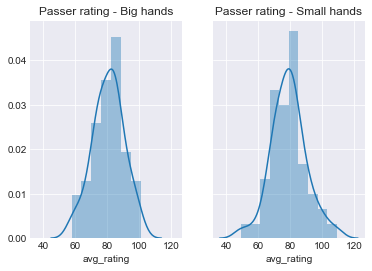

In [212]:
f, axes = plt.subplots(1,2, sharey=True, sharex=True)
sns.distplot(big_hands, ax=axes[0])
axes[0].set_title('Passer rating - Big hands')
sns.distplot(small_hands, ax=axes[1])
axes[1].set_title('Passer rating - Small hands')
plt.show()
# on first glance they look more or less the same

Because of the relatively small sample sizes we assume our distributions are of the students-t distribution (Kruschke).
The students-t has a mean, variance, and degree-of-freedom.
The degree of freedom control the normality of the data (larger dof converges to normal distribution).

Lets set up the model

In [213]:
# priors on the mean
m_mu = pd.concat([small_hands,big_hands]).mean()
m_sd = pd.concat([small_hands,big_hands]).std()

with pm.Model() as model:
    big_mean = pm.Normal('big_mean', mu=m_mu, sd=m_sd)
    small_mean = pm.Normal('small_mean', mu=m_mu, sd=m_sd)

In [214]:
# priors on the standard deviation
sd_low = 1
sd_high = 30

with model:
    big_std = pm.Uniform('big_std', lower=sd_low, upper=sd_high)
    small_std = pm.Uniform('small_std', lower=sd_low, upper=sd_high)

In [215]:
# shared prior on the degree of freedom parameter
with model:
    v = pm.Exponential('v_minus_one', 1/29.) + 1

In [216]:
# pymc3 paramaterises students t with precision, rather than standard deviation (lambda = 1/sigma^2)
with model:
    big_lambda = big_std**-2  # deterministic
    small_lambda = small_std**-2 # deterministic

    big_rating = pm.StudentT('big_hands', nu=v, mu=big_mean, lam=big_lambda, observed=big_hands)
    small_rating = pm.StudentT('small_hands', nu=v, mu=small_mean, lam=small_lambda, observed=small_hands)

In [217]:
with model:
    # our deterministic values, we could just have easily done this with the traces.
    diff_of_means = pm.Deterministic('difference_of_means', big_mean - small_mean)
    diff_of_stds = pm.Deterministic('difference_of_stds', big_std - small_std)
    effect_size = pm.Deterministic('effect_size',
                                   diff_of_means / np.sqrt((big_std**2 + small_std**2) / 2)) # hard to interpret but is difference scaled by pooled variance

In [218]:
with model:
    trace = pm.sample(2000) # NUTS sampling for filling our posterior

    # dump the trace
    today = dt.now().strftime('%y%m%d')
    with open(f'trace_qbhands_{today}.pckle', 'wb') as f:
        pickle.dump(trace, f)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_minus_one, small_std, big_std, small_mean, big_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:15<00:00, 323.59draws/s]


In [219]:
# with open('trace_qbhands.pckle', 'rb') as f:
#     trace = pickle.load(f)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002889AF5B308>,
      dtype=object)

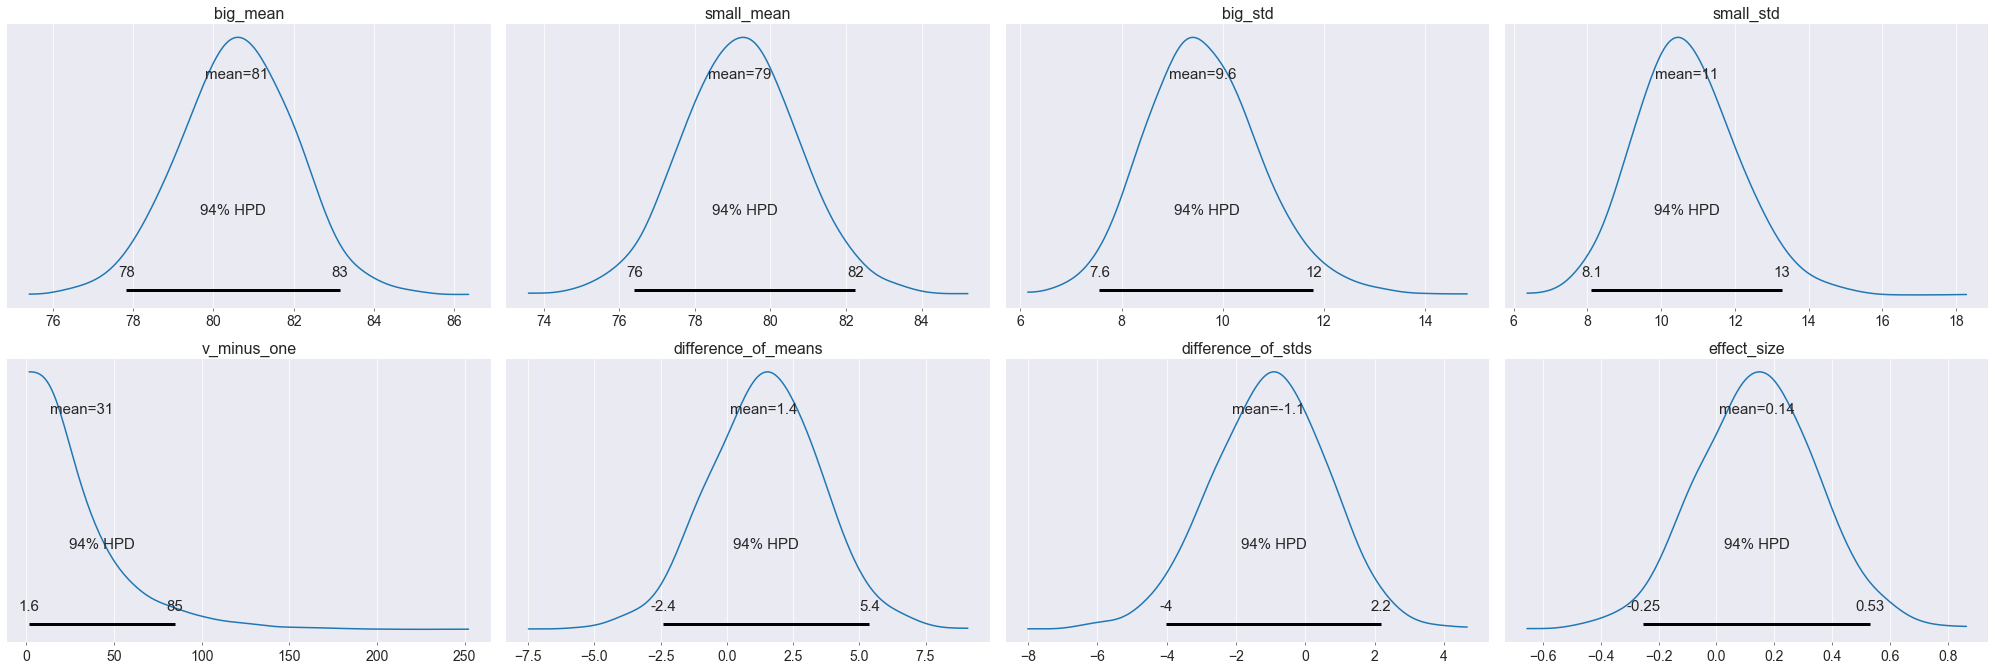

In [220]:
pm.plot_posterior(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002889919BFC8>,
      dtype=object)

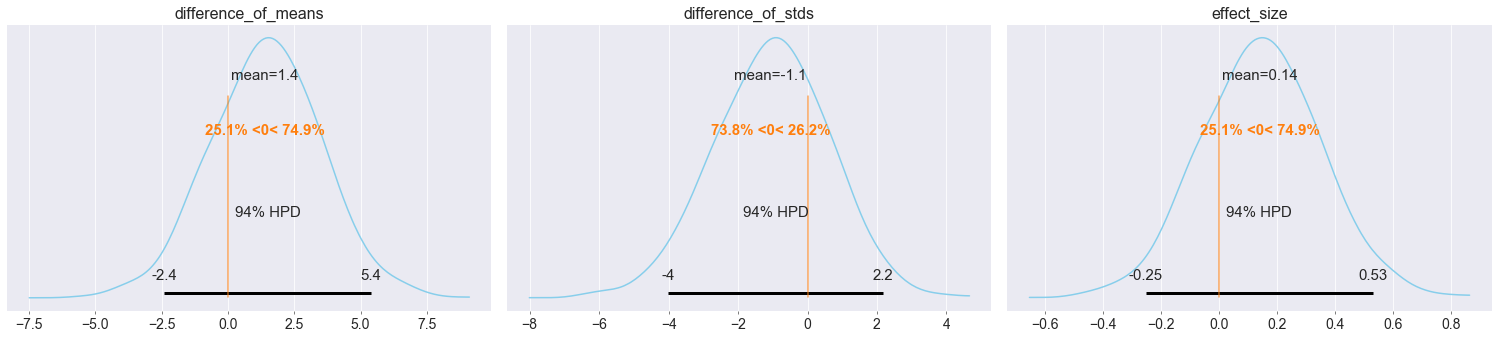

In [221]:
pm.plot_posterior(trace, var_names=['difference_of_means','difference_of_stds', 'effect_size'],
                  ref_val=0,
                  color='#87ceeb')

We see the difference is small but more than likely it's an advantage to have a larger hand, at least in terms of passer rating (which is an empirical measurement).

In [222]:
from util.stats import summary
summary_ = summary(trace)
summary_ # error out

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
big_mean,80.577471,1.423937,0.025105,77.575202,83.154658,3517.387455,0.999789
small_mean,79.185665,1.545888,0.023907,76.125135,82.217197,3837.047576,0.999839
big_std,9.606786,1.135115,0.019004,7.366192,11.816102,4053.234339,0.999870
small_std,10.679571,1.375229,0.024188,8.132126,13.533042,3192.206091,0.999928
v_minus_one,31.323827,28.626941,0.502334,1.724260,89.598221,3294.093015,0.999808
difference_of_means,1.391806,2.091036,0.034929,-2.670221,5.462838,3593.745853,0.999758
difference_of_stds,-1.072785,1.669681,0.023733,-4.334782,2.170740,4832.583601,0.999763
effect_size,0.139715,0.207705,0.003502,-0.251467,0.561698,3578.507000,0.999757


## TODO: Relative difference in means/lift.